# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

/home/ubuntu/anaconda2/envs/py34/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8479465200153713215
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 358350848
locality {
  bus_id: 1
}
incarnation: 7253800780225507143
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


In [3]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import pathlib
import imageio
import utils
import model as modellib
import visualize
import pandas as pd
import pdb

from skimage.io import imread, imread_collection
from config import Config
from model import log


%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
    
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

## Configurations

In [16]:
class NucleiConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a name
    NAME = "shapes"

    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 shapes

    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels
    
    TRAIN_ROIS_PER_IMAGE = 128
    MAX_GT_INSTANCES = 200
    DETECTION_MAX_INSTANCES = 400

    STEPS_PER_EPOCH = 600//IMAGES_PER_GPU
    VALIDATION_STEPS = 70//IMAGES_PER_GPU  
    USE_MINI_MASK=False    
    DETECTION_NMS_THRESHOLD = 0.9
    
config = NucleiConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]
 [  8   8]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.0
GPU_COUNT                      1
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  512
IMAGE_MIN_DIM                  512
IMAGE_PADDING                  True
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           shapes
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING        

## Notebook Preferences

In [5]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [6]:
class NucleiDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self,image_paths):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("nucleus", 1, "nucleus")
        
        for i, path in enumerate(list(image_paths)):
            
            im_path = next(pathlib.Path(path).glob('images/*.png'))
            mask_path_iter = pathlib.Path(path).glob('masks/*.png')
            h , t = os.path.split(im_path)                                        
            im = imread(im_path)
            
            self.add_image("nucleus", image_id=os.path.splitext(t)[0], path=im_path, \
                           width=im.shape[0], height=im.shape[1], \
                           mask_path_iter=mask_path_iter)

    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = imread(self.image_info[image_id]['path'])

        return image[:,:, :3]

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        mask = imread(next(info['mask_path_iter']))
        class_ids = np.ones((1), np.int32)         

        for m in info['mask_path_iter']:
            mask = np.dstack((mask, imread(m)))
            class_ids = np.hstack((class_ids, np.ones((1), np.int32)))
            
        return mask, class_ids
        

In [7]:
os.getcwd()

'/home/ubuntu/Mask_RCNN'

In [9]:
# Training dataset
training_paths = pathlib.Path('/home/ubuntu/datasciencebowl2018/stage1_train').glob('*')
val_paths = pathlib.Path('/home/ubuntu/datasciencebowl2018/stage1_val').glob('*')
test_paths = pathlib.Path('/home/ubuntu/datasciencebowl2018/stage1_test').glob('*')

# pdb.set_trace()
dataset_train = NucleiDataset()
dataset_train.load_shapes(training_paths)
dataset_train.prepare()

# Validation dataset
dataset_val = NucleiDataset()
dataset_val.load_shapes(val_paths)
dataset_val.prepare()

dataset_test = NucleiDataset()
dataset_test.load_shapes(test_paths)
dataset_test.prepare()

In [10]:
dataset_train.image_info[555]

{'height': 360,
 'id': '4c032609d377bd980e01f888e0b298600bf8af0e33c4271a1f3aaf76964dce06',
 'mask_path_iter': <generator object Path.glob at 0x7f47a6bd6bf8>,
 'path': PosixPath('/home/ubuntu/datasciencebowl2018/stage1_train/4c032609d377bd980e01f888e0b298600bf8af0e33c4271a1f3aaf76964dce06/images/4c032609d377bd980e01f888e0b298600bf8af0e33c4271a1f3aaf76964dce06.png'),
 'source': 'nucleus',
 'width': 360}

In [11]:
dataset_test.image_info[0]

{'height': 256,
 'id': '38f5cfb55fc8b048e82a5c895b25fefae7a70c71ab9990c535d1030637bf6a1f',
 'mask_path_iter': <generator object Path.glob at 0x7f47a6b20410>,
 'path': PosixPath('/home/ubuntu/datasciencebowl2018/stage1_test/38f5cfb55fc8b048e82a5c895b25fefae7a70c71ab9990c535d1030637bf6a1f/images/38f5cfb55fc8b048e82a5c895b25fefae7a70c71ab9990c535d1030637bf6a1f.png'),
 'source': 'nucleus',
 'width': 256}

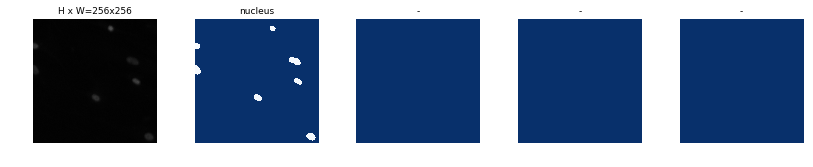

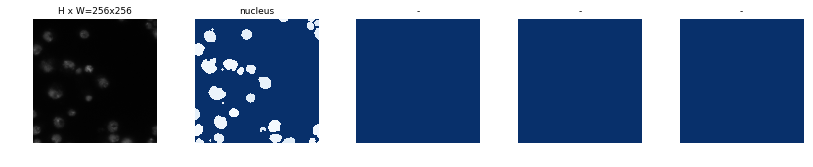

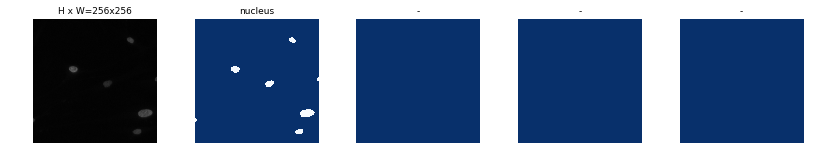

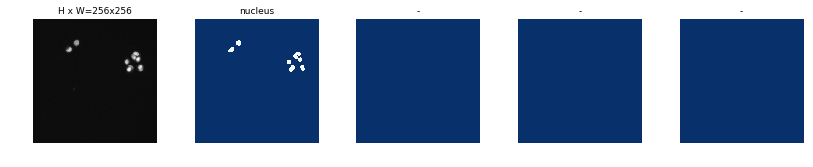

In [12]:
# dataset_train.image_ids

# pdb.set_trace()
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [17]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [18]:
# Which weights to start with?
init_with = "load"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model
    model.load_weights(model.find_last()[1], by_name=True)
    
elif init_with == "load":
    model.load_weights(os.path.join(MODEL_DIR, "mask_rcnn_shapes_v8_3e.h5"))

Which weights to start with

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [ ]:
# Train the head branches
model.train(dataset_train, dataset_train, 
            learning_rate=config.LEARNING_RATE, 
            epochs=20, 
            layers='heads')

# Fine tune all layers
# model.train(dataset_train, dataset_val, 
#             learning_rate=config.LEARNING_RATE / 10,
#             epochs=2, 
#             layers="all")

wt_filename = "mask_rcnn_shapes_v8_4e.h5"
model_path = os.path.join(MODEL_DIR, wt_filename)
model.keras_model.save_weights(model_path)

## Detection

In [20]:
class InferenceConfig(NucleiConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
model_path = os.path.join(MODEL_DIR, wt_filename)

# Load trained weights
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/ubuntu/Mask_RCNN/logs/mask_rcnn_shapes_v8_4e.h5


In [21]:
# Loop through labels and add each to a DataFrame
import datetime

def create_csv(dataset, model):
    
    im_df = pd.DataFrame()

    for m in dataset.image_ids:

        image = dataset.load_image(m)
        results = model.detect([image], verbose=1)
        r = results[0]

        for i in range(r['masks'].shape[2]):
            rle = rle_encoding(r['masks'][:, :, i])
            rle = ' '.join(np.array(rle).astype(str))
            s = pd.Series({'ImageId': dataset.image_info[m]['id'], 'EncodedPixels': rle})

            im_df = im_df.append(s, ignore_index=True)

#     csv_filename = 'submission' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '.csv'
    csv_filename = 'submission' + wt_filename[0:-3] + '.csv'
    im_df[['ImageId', 'EncodedPixels']].to_csv(csv_filename, index=None)
    

create_csv(dataset_test, model)

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  101.00000
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:   -3.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  512.00000
Processing 1 images
image                    shape: (519, 253, 3)         min:   11.00000  max:  211.00000
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  107.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  519.00000
Processing 1 images
image                    shape: (512, 640, 3)         min:    0.00000  max:  192.00000
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   65.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  640.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:   10.00000  max:  255.00000
molded_images            shape: (1, 512, 512, 3)  

In [ ]:
# Load and display random samples
image_id = random.choice(dataset_train.image_ids)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [ ]:
# Test on a random image
# image_id = random.choice(dataset_val.image_ids)
# image_id = random.choice(dataset_train.image_ids)
# image = dataset_train.load_image(image_id)

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]

visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_train.class_names, r['scores'], ax=get_ax())

In [ ]:
original_image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_train, inference_config, 
                           image_id, use_mini_mask=False)
log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
image_ids = np.random.choice(dataset_train.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_train, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))
print("precison: ", precisions)
print("recalls: ", recalls)
print("overlaps: ", overlaps)